# Project enda : Example D


If you have not installed or tested enda yet, please follow the instructions in example A. 


In this example we will set up a simple dayahead energy production prediction.  

We here pretend we are **exactly on 2021-01-01**. We want to predict the production of several power plants for the next few days on a 30 min time-step interval, until **2021-01-10**. 
In this example we will consider historical data is available over the whole year 2020. For testing purposes, we will build a single datframe containing data from 2020-01-01 until '2021-01-10', before dividing it into a historical training dataset (over the whole year 2020), and a forecast dataset that will contain data from 2021-01-02 to 2021-01-10. This approach is quite usual in the machine learning field, for backtesting purposes for instance, and has already been used in Example A. 

The data will be stored into several files that are likely to be the ones obtained from a typical ETL processing. Notably, we always separate the data according to the type of power plant (solar, wind, run of river), because they have very different behaviour. We thus consider:

- a list of stations with their associated installed capacity in kW (`wind_stations.csv`, `solar_stations.csv`, `river_stations.csv`). These files summarize contracts we may have with the aforementioned producers. 

- power generation for the power stations along the year 2020 (+ the first days of 2021 for testing purposes). Note this has to be obtained by yourself according to your needs (as an example, data used by Enercoop is regularly published by the French TSO)

- wheather for the power stations along the year 2020 (+ the first days of 2021 for the forecasting). This also needs to be obtained on your side (as an example, Enercoop regularly gather meteo information from GFS).

- a list of events (planned shutdowns or unexpected outages) that may have disrupted the regular installed capacity of the power stations. 


We will : 
- set up the relevant training and forecasting dataset ;
- do some feature engineering ;
- set up several models of training ;
- predict the dayahead energy production per power plant, and display its aggregated counterpart. 

In [1]:
import enda
import datetime
import matplotlib.pyplot as plt
import os
import pandas as pd
import time

# pandas option 
pd.options.display.max_columns = None
pd.options.display.max_colwidth = 30

# matplotlib in interactive mode
%matplotlib notebook

In [2]:
DIR_TEST = '.'

## Portfolio

Usually, contracts are set up with power producers so that a power stations portfolio is well-known in advance. This behaviour is slightly different from what happens on the consumption side, as customer are likely to end their contract whenever they want. 

In [3]:
# The details of power stations can be interpreted as ENDA contracts. 
# Loop over the different sources

generation_source = ["wind", "solar", "river"]

stations_wind =  enda.Contracts.read_contracts_from_file(os.path.join(
    DIR_TEST, generation_source[0], 
    "stations_" + generation_source[0] + ".csv")
)
stations_solar = enda.Contracts.read_contracts_from_file(os.path.join(
    DIR_TEST, generation_source[1], 
    "stations_" + generation_source[1] + ".csv")
)
stations_river = enda.Contracts.read_contracts_from_file(os.path.join(
    DIR_TEST, generation_source[2], 
    "stations_" + generation_source[2] + ".csv")
)

stations = dict(zip(generation_source, [stations_wind, stations_solar, stations_river]))


In [4]:
_ = [display(key, contracts) for key, contracts in stations.items()]

'wind'

station date_start date_end_exclusive  installed_capacity_kw
0    eo_1 2018-01-01         2023-01-01                 1200.0
1    eo_2 2019-12-07         2020-10-15                 1800.0
2    eo_3 2018-01-01         2021-04-08                 5700.0
3    eo_4 2018-07-01         2020-02-19                 3750.0
4    eo_4 2020-02-19         2022-01-01                 3000.0

'solar'

station date_start date_end_exclusive  installed_capacity_kw
0    pv_1 2019-10-01         2029-10-01                     75
1    pv_2 2019-09-04         2024-09-01                     36
2    pv_3 2019-04-01         2039-01-01                    250
3    pv_4 2019-10-01         2024-10-01                     42

'river'

station date_start date_end_exclusive  installed_capacity_kw
0    hy_1 2018-01-01         2024-01-01                 1300.0
1    hy_2 2018-01-01         2023-01-01                  850.0
2    hy_3 2018-01-01         2021-01-01                  580.0
3    hy_4 2018-01-01         2020-07-09                   90.0

For this example, we have chosen to consider four power stations of each type. As we'll see, this is probably not enough to produce a quality prediction. This is only made for the purposes of the present test.  

Exactly as contracts data, we have a starting and an ending date, and some characteristics which remain valid over that time lap. One may note the ending date is properly set in most cases. This differs from consumption contracts (cf. Example A), for which no ending date are provided for active contracts in most cases. The most important feature to consider is the installed capacity of the power stations. Prediction cannot be made without that information. 

We want to get the detail of the power stations on a daily basis. Here, a change of installed capacity is spotted for ```eo_4```. This has to be taken care of. 

In [5]:
# All enda functions in this notebook example are defined through wrappers not to repeat each function argument. 
# We turn the contracts-like data in a multiindex dataframe with two index. 
# The first one defines the unique id of each power station. 
# The second one is a DatetimeIndex, for now defined on a daily scale. 

def wrapper_get_stations_daily(df):
    return enda.PowerStations.get_stations_daily(
               df, 
               station_col='station',
               date_start_col="date_start",
               date_end_exclusive_col="date_end_exclusive"
           )

stations_daily = {source: wrapper_get_stations_daily(station) for source, station in stations.items()}

In [6]:
display(stations_daily["wind"])

installed_capacity_kw
station date                             
eo_1    2018-01-01                 1200.0
        2018-01-02                 1200.0
        2018-01-03                 1200.0
        2018-01-04                 1200.0
        2018-01-05                 1200.0
...                                   ...
eo_4    2021-12-27                 3000.0
        2021-12-28                 3000.0
        2021-12-29                 3000.0
        2021-12-30                 3000.0
        2021-12-31                 3000.0

[4612 rows x 1 columns]

We do not need to keep data before 2020 and after a few days of 2021, as we do not have weather forecast nor production data out of this interval.  

In [7]:
# Get the portfolio between dates
# We keep data between 2020-01-01 and 2021-01-11. 
# We will divide it between train and test sets at the end of the processing

def wrapper_get_stations_between_dates(df):
    return enda.PowerStations.get_stations_between_dates(
               df, 
               start_datetime = pd.to_datetime('2020-01-01'),
               end_datetime_exclusive = pd.to_datetime('2021-01-11')
           )

stations_daily = {source: wrapper_get_stations_between_dates(station) for source, station in stations_daily.items()}

In [8]:
display(stations_daily["wind"])

installed_capacity_kw
station date                             
eo_1    2020-01-01                 1200.0
        2020-01-02                 1200.0
        2020-01-03                 1200.0
        2020-01-04                 1200.0
        2020-01-05                 1200.0
...                                   ...
eo_4    2021-01-06                 3000.0
        2021-01-07                 3000.0
        2021-01-08                 3000.0
        2021-01-09                 3000.0
        2021-01-10                 3000.0

[1416 rows x 1 columns]

In [9]:
# Let's check 'eo_4' 
stations_wind_daily = stations_daily["wind"]
dates_test = [datetime.datetime(2020, 2, 17) + datetime.timedelta(days=x) for x in range(4)]
stations_wind_daily[(stations_wind_daily.index.get_level_values("station") == "eo_4") &
                    (stations_wind_daily.index.get_level_values("date").isin(dates_test))
                   ]

installed_capacity_kw
station date                             
eo_4    2020-02-17                 3750.0
        2020-02-18                 3750.0
        2020-02-19                 3000.0
        2020-02-20                 3000.0

At this point, we have a multiindexed dataframe containing the right installed capcity information for each power station at each day of interest.

We will make our prediction and training on a 30-minutes scale. We can use enda built-in functions to resample the dataframe on a 30-minute scale. This will serve when building the whole training dtaset.

In [10]:
# interpolate data to a sub-daily scale using enda.

def wrapper_interpolate_stations_to_subdaily_data(df):
    return enda.TimeSeries.interpolate_daily_to_sub_daily_data(
               df,
               freq='30min', 
               tz='Europe/Paris', 
               index_name='time'
           )

stations_30min_grid = {source: wrapper_interpolate_stations_to_subdaily_data(station) for source, station in stations_daily.items()}

In [11]:
display(stations_30min_grid["wind"])

installed_capacity_kw
station time                                            
eo_1    2020-01-01 00:00:00+01:00                 1200.0
        2020-01-01 00:30:00+01:00                 1200.0
        2020-01-01 01:00:00+01:00                 1200.0
        2020-01-01 01:30:00+01:00                 1200.0
        2020-01-01 02:00:00+01:00                 1200.0
...                                                  ...
eo_4    2021-01-10 21:30:00+01:00                 3000.0
        2021-01-10 22:00:00+01:00                 3000.0
        2021-01-10 22:30:00+01:00                 3000.0
        2021-01-10 23:00:00+01:00                 3000.0
        2021-01-10 23:30:00+01:00                 3000.0

[67966 rows x 1 columns]

### Take into account outages

At this point we have the portfolio information per day over the period of interest. During that time, some outages or shutdown may have occured. Such outages have a strong incidence on the quality of the prediction. In fact, they correspond to periods during which the installed capacity of the station is not fully avalaible. It is relevant to integrate these events, which modify our portfolio's installed capacity. Enda expects an independent file recensing the outages. 

In [12]:
# Read outages file. It is in the test dir. 
filepath =  os.path.join(DIR_TEST, "events.csv")

outages = enda.PowerStations.read_outages_from_file(
    filepath, 
    station_col='station',
    time_start_col="time_start", 
    time_end_exclusive_col="time_end", 
    pct_outages_col="impact_production_pct_kw",
    tzinfo="Europe/Paris"
)

In [13]:
display(outages)

station                time_start                  time_end  \
0    eo_2 2020-02-24 00:00:00+01:00 2020-03-25 00:00:00+01:00   
1    eo_3 2020-04-02 00:00:00+02:00 2020-04-03 00:00:00+02:00   
2    hy_4 2020-05-17 00:00:00+02:00 2020-07-18 00:00:00+02:00   
3    hy_2 2020-10-01 00:00:00+02:00 2020-11-16 00:00:00+01:00   

   impact_production_pct_kw event_type  
0                     100.0        NaN  
1                     100.0        NaN  
2                     100.0        NaN  
3                     100.0   shutdown

In [14]:
# wrapper to integrate the outages to the stations portfolio.
def wrapper_integrate_outages_to_stations(df):
    return enda.PowerStations.integrate_outages(
        stations=df,   
        outages=outages, 
        station_col="station",
        time_start_col="time_start",
        time_end_exclusive_col="time_end", 
        installed_capacity_col="installed_capacity_kw",
        pct_outages_col="impact_production_pct_kw"
    )

stations_portfolio = {source: wrapper_integrate_outages_to_stations(station) 
                      for source, station in stations_30min_grid.items()}

In [15]:
display(stations_portfolio["wind"])

installed_capacity_kw
station time                                            
eo_1    2020-01-01 00:00:00+01:00                 1200.0
        2020-01-01 00:30:00+01:00                 1200.0
        2020-01-01 01:00:00+01:00                 1200.0
        2020-01-01 01:30:00+01:00                 1200.0
        2020-01-01 02:00:00+01:00                 1200.0
...                                                  ...
eo_4    2021-01-10 21:30:00+01:00                 3000.0
        2021-01-10 22:00:00+01:00                 3000.0
        2021-01-10 22:30:00+01:00                 3000.0
        2021-01-10 23:00:00+01:00                 3000.0
        2021-01-10 23:30:00+01:00                 3000.0

[67966 rows x 1 columns]

In [16]:
# Check the outages have been corectly taken into account 
stations_wind_daily = stations_portfolio["wind"]
stations_wind_daily.loc[(stations_wind_daily.index.get_level_values("station") == "eo_2")
                    & (stations_wind_daily.index.get_level_values("time") >= pd.to_datetime('2020-02-23 22:00:00+01:00'))
                    & (stations_wind_daily.index.get_level_values("time") < pd.to_datetime('2020-02-24 02:00:00+01:00'))
                   ]

installed_capacity_kw
station time                                            
eo_2    2020-02-23 22:00:00+01:00                 1800.0
        2020-02-23 22:30:00+01:00                 1800.0
        2020-02-23 23:00:00+01:00                 1800.0
        2020-02-23 23:30:00+01:00                 1800.0
        2020-02-24 00:00:00+01:00                    0.0
        2020-02-24 00:30:00+01:00                    0.0
        2020-02-24 01:00:00+01:00                    0.0
        2020-02-24 01:30:00+01:00                    0.0

### Plot the portfolio 

Let's just plot the evolution of the installed capacity of our power plants, to get an immediate idea of the importance of the outages. 


<IPython.core.display.Javascript object>


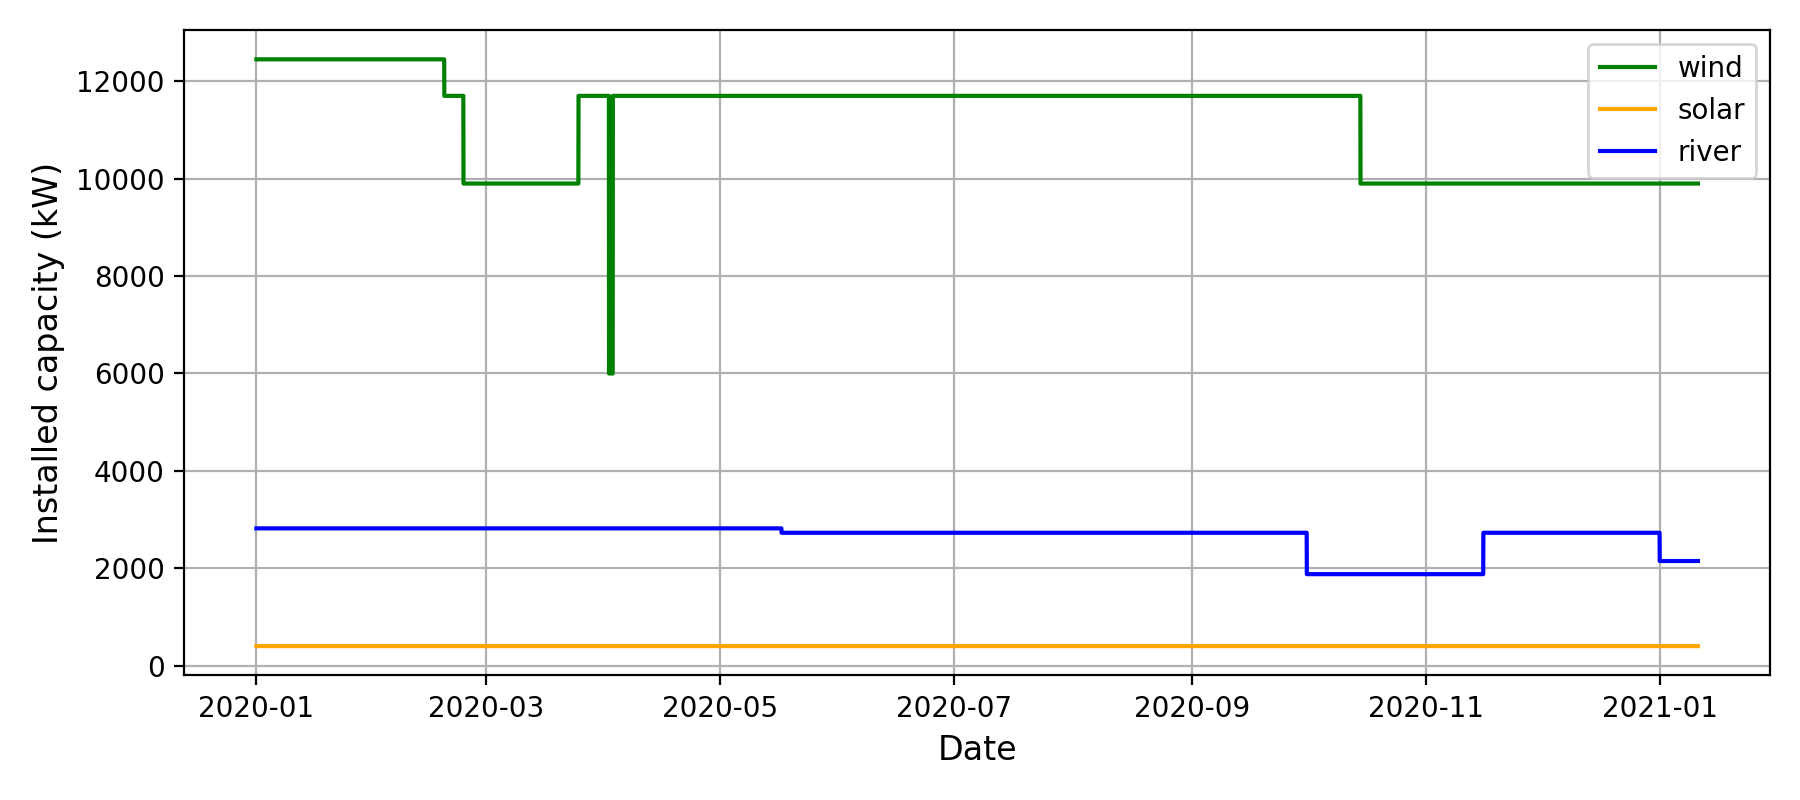

In [17]:
# We use matplotlib in interactive mode

# Set colors
colors = ["green", "orange", "blue"]
colors = dict(zip(generation_source, colors))

fig, axis = plt.subplots(1, 1, figsize=(9, 4), sharex=True, sharey=False)
axis.grid(True)
for source, stations in stations_portfolio.items():
    axis.plot(stations["installed_capacity_kw"].groupby(level=1).agg("sum"), label=source, c=colors[source])
    axis.set_xlabel('Date', fontsize=12)
    axis.set_ylabel('Installed capacity (kW)', fontsize=12)
    
axis.legend()
fig.tight_layout()

# Weather forecasting

Weather forecasts have been retrieved over the period of interest. This is a huge step of the process, as the weather forecast data must correspond to the specific location of each power station. Moreover, retrieving the data from a weather forecats provider might be a tedious process. Here we use weather forecast for solar and wind stations only. We use for the wind power stations: 
- the north-south wind speed at 80m (known as 'ugrd') 
- the east-west wind speed at 80m (known as 'vgrd') 
and for the solar stations: 
- the average downard short-wave radiation flux ([W.m^-2])
- the average total cloud cover (%)

Such data has been interpolated here at the power stations location. 
Weather forecast are provided here on a 3h-timestep. We need to set them on the frequency of interest, which is a 30 minutes. 

In [18]:
# Retrieve weather information. We only have it for solar and wind stations
weather_forecast_wind = pd.read_csv(os.path.join(DIR_TEST, "wind", "weather_forecast_wind.csv"),
                                    parse_dates=["time"],
                                    date_parser=lambda col: pd.to_datetime(col, utc=True)
                        )
weather_forecast_solar = pd.read_csv(os.path.join(DIR_TEST, "solar", "weather_forecast_solar.csv"), 
                                     parse_dates=["time"],
                                     date_parser=lambda col: pd.to_datetime(col, utc=True)
                         )

# The datetime object is a mixture of timezone, due to the summer/winter clock change.
# we must fix it. We also turn the weather forecast to a multi-index dataframe. 
for df in [weather_forecast_wind, weather_forecast_solar]:
    df['time'] = enda.TimeSeries.align_timezone(df['time'], tzinfo = 'Europe/Paris')
    df.set_index(["station", "time"], inplace=True)
    
weather_forecast = dict(zip(generation_source, [weather_forecast_wind, weather_forecast_solar]))

In [19]:
_ = [display(source, weather) for source, weather in weather_forecast.items()]

'wind'

north_south_wind_speed  \
station time                                                
eo_1    2020-01-01 01:00:00+01:00                2.597016   
        2020-01-01 04:00:00+01:00                1.937216   
        2020-01-01 07:00:00+01:00                1.551544   
        2020-01-01 10:00:00+01:00                2.848144   
        2020-01-01 13:00:00+01:00                3.525401   
...                                                   ...   
eo_4    2021-01-10 10:00:00+01:00               -1.833760   
        2021-01-10 13:00:00+01:00               -0.326291   
        2021-01-10 16:00:00+01:00                0.574670   
        2021-01-10 19:00:00+01:00               -0.158614   
        2021-01-10 22:00:00+01:00                0.389224   

                                   east_west_wind_speed  
station time                                             
eo_1    2020-01-01 01:00:00+01:00              1.182768  
        2020-01-01 04:00:00+01:00             -0.226259  
        2020-01-01 07:00:00+01:00              0.671936  
        2020-01-01 10:00:00+01:00              0.341427  
        2020-01-01 13:00:00+01:00              0.134690  
...                                                 ...  
eo_4    2021-01-10 10:00:00+01:00             -2.016496  
        2021-01-10 13:00:00+01:00             -4.157018  
        2021-01-10 16:00:00+01:00             -4.930278  
        2021-01-10 19:00:00+01:00             -4.789784  
        2021-01-10 22:00:00+01:00             -4.677192  

[12032 rows x 2 columns]

'solar'

downard_short_wave_radiation  \
station time                                                      
pv_1    2020-01-01 01:00:00+01:00                        0.0000   
        2020-01-01 04:00:00+01:00                        0.0000   
        2020-01-01 07:00:00+01:00                        0.0000   
        2020-01-01 10:00:00+01:00                       10.0000   
        2020-01-01 13:00:00+01:00                      177.5732   
...                                                         ...   
pv_4    2021-01-10 10:00:00+01:00                       20.0000   
        2021-01-10 13:00:00+01:00                      260.0000   
        2021-01-10 16:00:00+01:00                      260.0000   
        2021-01-10 19:00:00+01:00                       20.0000   
        2021-01-10 22:00:00+01:00                        0.0000   

                                   total_cloud_cover  
station time                                          
pv_1    2020-01-01 01:00:00+01:00         100.000000  
        2020-01-01 04:00:00+01:00         100.000000  
        2020-01-01 07:00:00+01:00         100.000000  
        2020-01-01 10:00:00+01:00         100.000000  
        2020-01-01 13:00:00+01:00          77.511296  
...                                              ...  
pv_4    2021-01-10 10:00:00+01:00           0.000000  
        2021-01-10 13:00:00+01:00           0.000000  
        2021-01-10 16:00:00+01:00           0.136362  
        2021-01-10 19:00:00+01:00          11.913029  
        2021-01-10 22:00:00+01:00           0.518630  

[12032 rows x 2 columns]

Let us linearly interpolate the forecasts on a 30-minutes time-step. As a rather continuous data, it makes sense. 

In [20]:
# Interpolate the forecasts to a 30-minutes scale

def wrapper_interpolate_freq_to_sub_freq_data(df):
    return enda.TimeSeries.interpolate_freq_to_sub_freq_data(
               df,
               freq='30min', 
               tz='Europe/Paris',
               index_name='time',
               method="linear"
           )

weather_forecast = {source: wrapper_interpolate_freq_to_sub_freq_data(w) 
                    for source, w in weather_forecast.items()}

In [21]:
weather_forecast["wind"]

north_south_wind_speed  \
station time                                                
eo_1    2020-01-01 01:00:00+01:00                2.597016   
        2020-01-01 01:30:00+01:00                2.487050   
        2020-01-01 02:00:00+01:00                2.377083   
        2020-01-01 02:30:00+01:00                2.267116   
        2020-01-01 03:00:00+01:00                2.157150   
...                                                   ...   
eo_4    2021-01-10 20:00:00+01:00                0.023999   
        2021-01-10 20:30:00+01:00                0.115305   
        2021-01-10 21:00:00+01:00                0.206611   
        2021-01-10 21:30:00+01:00                0.297918   
        2021-01-10 22:00:00+01:00                0.389224   

                                   east_west_wind_speed  
station time                                             
eo_1    2020-01-01 01:00:00+01:00              1.182768  
        2020-01-01 01:30:00+01:00              0.947930  
        2020-01-01 02:00:00+01:00              0.713092  
        2020-01-01 02:30:00+01:00              0.478255  
        2020-01-01 03:00:00+01:00              0.243417  
...                                                 ...  
eo_4    2021-01-10 20:00:00+01:00             -4.752253  
        2021-01-10 20:30:00+01:00             -4.733488  
        2021-01-10 21:00:00+01:00             -4.714723  
        2021-01-10 21:30:00+01:00             -4.695957  
        2021-01-10 22:00:00+01:00             -4.677192  

[72172 rows x 2 columns]

## Production

Get production information. This information is usually avaliable from the TSO. Here, it is provided on a fine 10-minutes timestep, and we need to average it over the half-hour scale.

Here, the production information has been retrieved over the year 2020, but also on the first days on 2021. Quite obvioulsy, this information was not available at that time, as forecasting it is the objective of this notebook. It has been kept for didactic purposes, as it will serve to estimate the quality of the model later.  

In [22]:
%%time

# Retrieve production information.
production_wind = pd.read_csv(os.path.join(DIR_TEST, "wind", "production_wind.csv"), 
                              parse_dates=["time"],
                              date_parser=lambda col: pd.to_datetime(col, utc=True)
                             )
production_solar = pd.read_csv(os.path.join(DIR_TEST, "solar", "production_solar.csv"),
                               parse_dates=["time"],
                               date_parser=lambda col: pd.to_datetime(col, utc=True)
                              )
production_river = pd.read_csv(os.path.join(DIR_TEST, "river", "production_river.csv"),
                               parse_dates=["time"],
                               date_parser=lambda col: pd.to_datetime(col, utc=True)
                              )

# The datetime object is a mixture of timezone, due to the summer/winter clock change.
# we must fix it. We also turn the production df to multi-index dataframes. 
for df in [production_wind, production_solar, production_river]:
    df['time'] = enda.TimeSeries.align_timezone(df['time'], tzinfo = 'Europe/Paris')
    df.set_index(["station", "time"], inplace=True)

production = dict(zip(generation_source, [production_wind, production_solar, production_river]))

CPU times: user 10.5 s, sys: 299 ms, total: 10.8 s
Wall time: 10.9 s


In [23]:
# let us display production for run of river stations, as as change
production["river"]

power_kw
station time                               
hy_1    2020-01-01 00:00:00+01:00      65.0
        2020-01-01 00:10:00+01:00      66.0
        2020-01-01 00:20:00+01:00      68.0
        2020-01-01 00:30:00+01:00      60.0
        2020-01-01 00:40:00+01:00      59.0
...                                     ...
hy_4    2020-07-08 23:10:00+02:00       0.0
        2020-07-08 23:20:00+02:00       0.0
        2020-07-08 23:30:00+02:00       0.0
        2020-07-08 23:40:00+02:00       0.0
        2020-07-08 23:50:00+02:00       0.0

[188346 rows x 1 columns]

In [24]:
# Let us average the production over a 30 minutes time scale.

def wrapper_average_to_upper_freq(df):
    return enda.TimeSeries.average_to_upper_freq(
               df,
               freq='30min', 
               tz='Europe/Paris',
               index_name='time'
           )

production = {source: wrapper_average_to_upper_freq(w) 
                    for source, w in production.items()}

In [25]:
production["river"]

power_kw
station time                                 
hy_1    2020-01-01 00:00:00+01:00   66.333333
        2020-01-01 00:30:00+01:00   58.333333
        2020-01-01 01:00:00+01:00  101.000000
        2020-01-01 01:30:00+01:00   79.333333
        2020-01-01 02:00:00+01:00   60.000000
...                                       ...
hy_4    2020-07-08 21:30:00+02:00    0.000000
        2020-07-08 22:00:00+02:00    0.000000
        2020-07-08 22:30:00+02:00    0.000000
        2020-07-08 23:00:00+02:00    0.000000
        2020-07-08 23:30:00+02:00    0.000000

[62782 rows x 1 columns]

### Plot the production 

Let's plot the production in (kW) summed over power plants of the same type

<IPython.core.display.Javascript object>


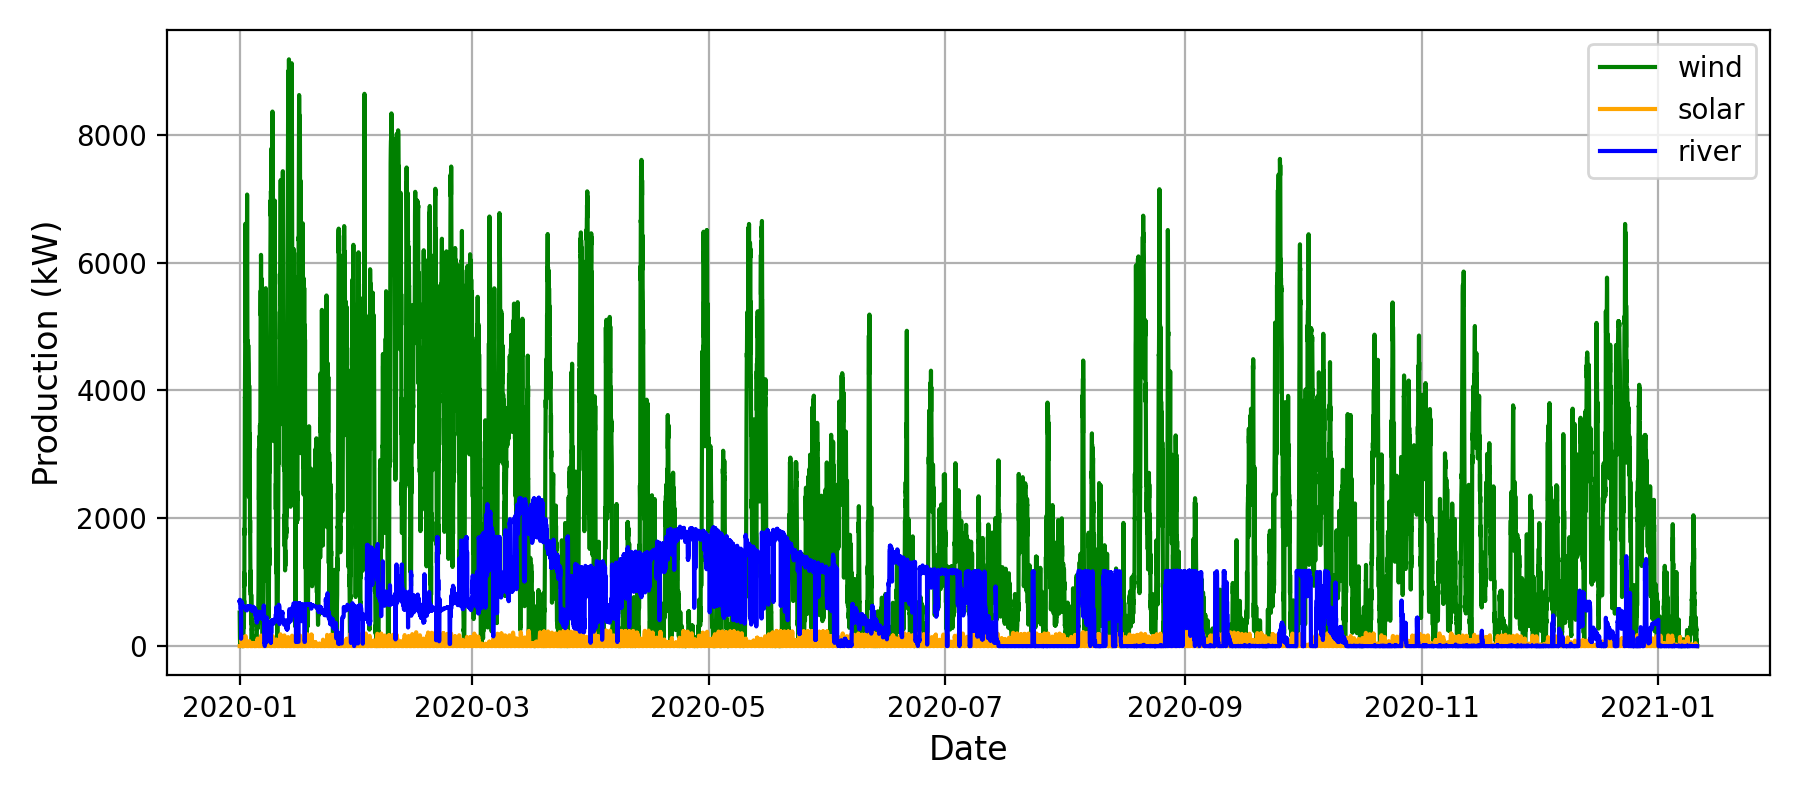

In [26]:
fig, axis = plt.subplots(1, 1, figsize=(9, 4), sharex=True, sharey=False)
axis.grid(True)

for source, stations in production.items():
    axis.plot(stations["power_kw"].groupby(level=1).agg("sum"), label=source, c=colors[source])
    axis.set_xlabel('Date', fontsize=12)
    axis.set_ylabel('Production (kW)', fontsize=12)
    
axis.legend()
fig.tight_layout()

## Merge portfolio, meteo, and production 

We gathered information about the power stations in our example portfolio over the year 2020, as well as production data and weather forecats (for solar and wind only). We managed to set them on a 30-minutes scale. We need to merge these data together to produce training sets that will serve for our prediction. 

In [27]:
# Function meant to perform an inner join of the dataframes based on the two indexes. 
def merge_stations_and_features(df1, df2):
    df = pd.merge(df1, df2, how='inner', left_index=True, right_index=True)
    return df.dropna()
    
dataset = dict()
for source in generation_source: 
    data = merge_stations_and_features(stations_portfolio[source], production[source])
    if source in ["wind", "solar"]:
        data = merge_stations_and_features(data, weather_forecast[source])
    dataset[source] = data

In [28]:
# Let us display all the dataframes
_ = [display(source, data) for source, data in dataset.items()]

'wind'

installed_capacity_kw   power_kw  \
station time                                                          
eo_1    2020-01-01 01:00:00+01:00                 1200.0   0.000000   
        2020-01-01 01:30:00+01:00                 1200.0   0.000000   
        2020-01-01 02:00:00+01:00                 1200.0   0.000000   
        2020-01-01 02:30:00+01:00                 1200.0   0.000000   
        2020-01-01 03:00:00+01:00                 1200.0   0.000000   
...                                                  ...        ...   
eo_4    2021-01-10 20:00:00+01:00                 3000.0  28.000000   
        2021-01-10 20:30:00+01:00                 3000.0  23.000000   
        2021-01-10 21:00:00+01:00                 3000.0  43.000000   
        2021-01-10 21:30:00+01:00                 3000.0  51.333333   
        2021-01-10 22:00:00+01:00                 3000.0   1.333333   

                                   north_south_wind_speed  \
station time                                                
eo_1    2020-01-01 01:00:00+01:00                2.597016   
        2020-01-01 01:30:00+01:00                2.487050   
        2020-01-01 02:00:00+01:00                2.377083   
        2020-01-01 02:30:00+01:00                2.267116   
        2020-01-01 03:00:00+01:00                2.157150   
...                                                   ...   
eo_4    2021-01-10 20:00:00+01:00                0.023999   
        2021-01-10 20:30:00+01:00                0.115305   
        2021-01-10 21:00:00+01:00                0.206611   
        2021-01-10 21:30:00+01:00                0.297918   
        2021-01-10 22:00:00+01:00                0.389224   

                                   east_west_wind_speed  
station time                                             
eo_1    2020-01-01 01:00:00+01:00              1.182768  
        2020-01-01 01:30:00+01:00              0.947930  
        2020-01-01 02:00:00+01:00              0.713092  
        2020-01-01 02:30:00+01:00              0.478255  
        2020-01-01 03:00:00+01:00              0.243417  
...                                                 ...  
eo_4    2021-01-10 20:00:00+01:00             -4.752253  
        2021-01-10 20:30:00+01:00             -4.733488  
        2021-01-10 21:00:00+01:00             -4.714723  
        2021-01-10 21:30:00+01:00             -4.695957  
        2021-01-10 22:00:00+01:00             -4.677192  

[67949 rows x 4 columns]

'solar'

installed_capacity_kw  power_kw  \
station time                                                         
pv_1    2020-01-01 01:00:00+01:00                   75.0       0.0   
        2020-01-01 01:30:00+01:00                   75.0       0.0   
        2020-01-01 02:00:00+01:00                   75.0       0.0   
        2020-01-01 02:30:00+01:00                   75.0       0.0   
        2020-01-01 03:00:00+01:00                   75.0       0.0   
...                                                  ...       ...   
pv_4    2021-01-10 20:00:00+01:00                   42.0       0.0   
        2021-01-10 20:30:00+01:00                   42.0       0.0   
        2021-01-10 21:00:00+01:00                   42.0       0.0   
        2021-01-10 21:30:00+01:00                   42.0       0.0   
        2021-01-10 22:00:00+01:00                   42.0       0.0   

                                   downard_short_wave_radiation  \
station time                                                      
pv_1    2020-01-01 01:00:00+01:00                      0.000000   
        2020-01-01 01:30:00+01:00                      0.000000   
        2020-01-01 02:00:00+01:00                      0.000000   
        2020-01-01 02:30:00+01:00                      0.000000   
        2020-01-01 03:00:00+01:00                      0.000000   
...                                                         ...   
pv_4    2021-01-10 20:00:00+01:00                     13.333333   
        2021-01-10 20:30:00+01:00                     10.000000   
        2021-01-10 21:00:00+01:00                      6.666667   
        2021-01-10 21:30:00+01:00                      3.333333   
        2021-01-10 22:00:00+01:00                      0.000000   

                                   total_cloud_cover  
station time                                          
pv_1    2020-01-01 01:00:00+01:00         100.000000  
        2020-01-01 01:30:00+01:00         100.000000  
        2020-01-01 02:00:00+01:00         100.000000  
        2020-01-01 02:30:00+01:00         100.000000  
        2020-01-01 03:00:00+01:00         100.000000  
...                                              ...  
pv_4    2021-01-10 20:00:00+01:00           8.114896  
        2021-01-10 20:30:00+01:00           6.215829  
        2021-01-10 21:00:00+01:00           4.316763  
        2021-01-10 21:30:00+01:00           2.417696  
        2021-01-10 22:00:00+01:00           0.518630  

[55422 rows x 4 columns]

'river'

installed_capacity_kw    power_kw
station time                                                        
hy_1    2020-01-01 00:00:00+01:00                 1300.0   66.333333
        2020-01-01 00:30:00+01:00                 1300.0   58.333333
        2020-01-01 01:00:00+01:00                 1300.0  101.000000
        2020-01-01 01:30:00+01:00                 1300.0   79.333333
        2020-01-01 02:00:00+01:00                 1300.0   60.000000
...                                                  ...         ...
hy_4    2020-07-08 21:30:00+02:00                    0.0    0.000000
        2020-07-08 22:00:00+02:00                    0.0    0.000000
        2020-07-08 22:30:00+02:00                    0.0    0.000000
        2020-07-08 23:00:00+02:00                    0.0    0.000000
        2020-07-08 23:30:00+02:00                    0.0    0.000000

[62782 rows x 2 columns]

## Featurize

Let's try to add some feature for the solar dataset, namely the cosine and sinus of dates, day and month. This provides a continuous feature representative of the moment of the day and year. These features are especially important for the solar generation.

In [29]:
# using enda.feature_engineering.calendar for solar
dataset["solar"] = enda.DatetimeFeature.split_datetime(dataset["solar"], split_list=['minuteofday', 'dayofyear'])

dataset["solar"] = enda.DatetimeFeature.encode_cyclic_datetime_index(dataset["solar"],
                                                                     split_list=['minuteofday', 'dayofyear'])


In [30]:
dataset["solar"]

installed_capacity_kw  power_kw  \
station time                                                         
pv_1    2020-01-01 01:00:00+01:00                   75.0       0.0   
        2020-01-01 01:30:00+01:00                   75.0       0.0   
        2020-01-01 02:00:00+01:00                   75.0       0.0   
        2020-01-01 02:30:00+01:00                   75.0       0.0   
        2020-01-01 03:00:00+01:00                   75.0       0.0   
...                                                  ...       ...   
pv_4    2021-01-10 20:00:00+01:00                   42.0       0.0   
        2021-01-10 20:30:00+01:00                   42.0       0.0   
        2021-01-10 21:00:00+01:00                   42.0       0.0   
        2021-01-10 21:30:00+01:00                   42.0       0.0   
        2021-01-10 22:00:00+01:00                   42.0       0.0   

                                   downard_short_wave_radiation  \
station time                                                      
pv_1    2020-01-01 01:00:00+01:00                      0.000000   
        2020-01-01 01:30:00+01:00                      0.000000   
        2020-01-01 02:00:00+01:00                      0.000000   
        2020-01-01 02:30:00+01:00                      0.000000   
        2020-01-01 03:00:00+01:00                      0.000000   
...                                                         ...   
pv_4    2021-01-10 20:00:00+01:00                     13.333333   
        2021-01-10 20:30:00+01:00                     10.000000   
        2021-01-10 21:00:00+01:00                      6.666667   
        2021-01-10 21:30:00+01:00                      3.333333   
        2021-01-10 22:00:00+01:00                      0.000000   

                                   total_cloud_cover  minuteofday  dayofyear  \
station time                                                                   
pv_1    2020-01-01 01:00:00+01:00         100.000000           60          1   
        2020-01-01 01:30:00+01:00         100.000000           90          1   
        2020-01-01 02:00:00+01:00         100.000000          120          1   
        2020-01-01 02:30:00+01:00         100.000000          150          1   
        2020-01-01 03:00:00+01:00         100.000000          180          1   
...                                              ...          ...        ...   
pv_4    2021-01-10 20:00:00+01:00           8.114896         1200         10   
        2021-01-10 20:30:00+01:00           6.215829         1230         10   
        2021-01-10 21:00:00+01:00           4.316763         1260         10   
        2021-01-10 21:30:00+01:00           2.417696         1290         10   
        2021-01-10 22:00:00+01:00           0.518630         1320         10   

                                   minuteofday_cos  minuteofday_sin  \
station time                                                          
pv_1    2020-01-01 01:00:00+01:00         0.965926         0.258819   
        2020-01-01 01:30:00+01:00         0.923880         0.382683   
        2020-01-01 02:00:00+01:00         0.866025         0.500000   
        2020-01-01 02:30:00+01:00         0.793353         0.608761   
        2020-01-01 03:00:00+01:00         0.707107         0.707107   
...                                            ...              ...   
pv_4    2021-01-10 20:00:00+01:00         0.500000        -0.866025   
        2021-01-10 20:30:00+01:00         0.608761        -0.793353   
        2021-01-10 21:00:00+01:00         0.707107        -0.707107   
        2021-01-10 21:30:00+01:00         0.793353        -0.608761   
        2021-01-10 22:00:00+01:00         0.866025        -0.500000   

                                   dayofyear_cos  dayofyear_sin  
station time                                                     
pv_1    2020-01-01 01:00:00+01:00       1.000000       0.000000  
        2020-01-01 01:30:00+01:00       1.000000       0.000000  
        2020-01-01 02:0

## Compute the load_factor

The **load factor** is the key target of the algorithm, that is the quantity to be forecast. It is simply the ratio of the instantaneous production to the installed capacity of a power plant.
Let's compute it from the `installed_capacity` and the `power_kw` fields.

In [31]:
# Compute load factor
# We drop the power_kw information during that step, not to bias the IA algorithm afterwards. 
def wrapper_compute_load_factor(df):
    return enda.PowerStations.compute_load_factor(
               df, 
               installed_capacity_kw='installed_capacity_kw', 
               power_kw='power_kw',
               drop_power_kw=True
           )           

dataset_final = {source: wrapper_compute_load_factor(d) for source, d in dataset.items()}

In [32]:
dataset_final["wind"]

installed_capacity_kw  \
station time                                               
eo_1    2020-01-01 01:00:00+01:00                 1200.0   
        2020-01-01 01:30:00+01:00                 1200.0   
        2020-01-01 02:00:00+01:00                 1200.0   
        2020-01-01 02:30:00+01:00                 1200.0   
        2020-01-01 03:00:00+01:00                 1200.0   
...                                                  ...   
eo_4    2021-01-10 20:00:00+01:00                 3000.0   
        2021-01-10 20:30:00+01:00                 3000.0   
        2021-01-10 21:00:00+01:00                 3000.0   
        2021-01-10 21:30:00+01:00                 3000.0   
        2021-01-10 22:00:00+01:00                 3000.0   

                                   north_south_wind_speed  \
station time                                                
eo_1    2020-01-01 01:00:00+01:00                2.597016   
        2020-01-01 01:30:00+01:00                2.487050   
        2020-01-01 02:00:00+01:00                2.377083   
        2020-01-01 02:30:00+01:00                2.267116   
        2020-01-01 03:00:00+01:00                2.157150   
...                                                   ...   
eo_4    2021-01-10 20:00:00+01:00                0.023999   
        2021-01-10 20:30:00+01:00                0.115305   
        2021-01-10 21:00:00+01:00                0.206611   
        2021-01-10 21:30:00+01:00                0.297918   
        2021-01-10 22:00:00+01:00                0.389224   

                                   east_west_wind_speed  load_factor  
station time                                                          
eo_1    2020-01-01 01:00:00+01:00              1.182768     0.000000  
        2020-01-01 01:30:00+01:00              0.947930     0.000000  
        2020-01-01 02:00:00+01:00              0.713092     0.000000  
        2020-01-01 02:30:00+01:00              0.478255     0.000000  
        2020-01-01 03:00:00+01:00              0.243417     0.000000  
...                                                 ...          ...  
eo_4    2021-01-10 20:00:00+01:00             -4.752253     0.009333  
        2021-01-10 20:30:00+01:00             -4.733488     0.007667  
        2021-01-10 21:00:00+01:00             -4.714723     0.014333  
        2021-01-10 21:30:00+01:00             -4.695957     0.017111  
        2021-01-10 22:00:00+01:00             -4.677192     0.000444  

[67949 rows x 4 columns]

## Distinguish between training and forecasting dataset

We have here the full datasets which have been built using the enda utilities function, and some historical information gathered from the TSO, diverse weather forecast suppliers, and contracts data with producers. 

These are artifical datasets for now, because they include the historical data (over the year 2020), and the period over which we want to be able to predict the power generation (the first days odf 2021). 

We will now cut the full datasets in two, in order to obtain training and forecasting datasets. They will be representative of what could be obtained in real life conditions. 

In [33]:
# Function to create train and forecast (test) dataset
def separate_train_test_sets(df):
    
    # let's create the input train dataset
    train_set = df[df.index.get_level_values(1) < pd.to_datetime('2021-01-01 00:00:00+01:00')]
        
    # let's create the input data for our forecast
    forecast_set = df[df.index.get_level_values(1) >= pd.to_datetime('2021-01-02 00:00:00+01:00')]
    forecast_set = forecast_set.drop(columns="load_factor")
    
    # and let us keep the information of the real power generation for testing purposes
    future_set = df[df.index.get_level_values(1) >= pd.to_datetime('2021-01-02 00:00:00+01:00')]

    return train_set, forecast_set, future_set

train_test_future_sets = {source: separate_train_test_sets(data) for source, data in dataset_final.items()} 

train_set = {source: train_test_future_sets[source][0] for source in generation_source}
forecast_set = {source: train_test_future_sets[source][1] for source in generation_source}
future_set = {source: train_test_future_sets[source][2] for source in generation_source}

In [34]:
forecast_set["wind"]

installed_capacity_kw  \
station time                                               
eo_1    2021-01-02 00:00:00+01:00                 1200.0   
        2021-01-02 00:30:00+01:00                 1200.0   
        2021-01-02 01:00:00+01:00                 1200.0   
        2021-01-02 01:30:00+01:00                 1200.0   
        2021-01-02 02:00:00+01:00                 1200.0   
...                                                  ...   
eo_4    2021-01-10 20:00:00+01:00                 3000.0   
        2021-01-10 20:30:00+01:00                 3000.0   
        2021-01-10 21:00:00+01:00                 3000.0   
        2021-01-10 21:30:00+01:00                 3000.0   
        2021-01-10 22:00:00+01:00                 3000.0   

                                   north_south_wind_speed  \
station time                                                
eo_1    2021-01-02 00:00:00+01:00               -0.327436   
        2021-01-02 00:30:00+01:00               -0.077917   
        2021-01-02 01:00:00+01:00                0.171601   
        2021-01-02 01:30:00+01:00                0.241003   
        2021-01-02 02:00:00+01:00                0.310404   
...                                                   ...   
eo_4    2021-01-10 20:00:00+01:00                0.023999   
        2021-01-10 20:30:00+01:00                0.115305   
        2021-01-10 21:00:00+01:00                0.206611   
        2021-01-10 21:30:00+01:00                0.297918   
        2021-01-10 22:00:00+01:00                0.389224   

                                   east_west_wind_speed  
station time                                             
eo_1    2021-01-02 00:00:00+01:00             -1.207094  
        2021-01-02 00:30:00+01:00             -1.065858  
        2021-01-02 01:00:00+01:00             -0.924621  
        2021-01-02 01:30:00+01:00             -1.012067  
        2021-01-02 02:00:00+01:00             -1.099513  
...                                                 ...  
eo_4    2021-01-10 20:00:00+01:00             -4.752253  
        2021-01-10 20:30:00+01:00             -4.733488  
        2021-01-10 21:00:00+01:00             -4.714723  
        2021-01-10 21:30:00+01:00             -4.695957  
        2021-01-10 22:00:00+01:00             -4.677192  

[1287 rows x 3 columns]

In [35]:
train_set["wind"].shape

(66518, 4)

# Make a prediction


Let's use the enda algorithms to make a simple power prediction. 

We need to import the ML backends from enda, as well as the enda wrapper which handles calculations specific to the power prediction, from the class PowerPredictor. This class wraps EndaEstimator objects. The retained appraoch is to consider the records of the several power stations as records of the same 'theoretical' power plant, which serve as a training dataset. This approach is called the standard power plant method. Individual properties of each plant are considered to be additional features of the algorithm: this is notably the case of the `installed_capacity` information. 

Here, we will use EndaEstimators (from Sklearn or H2O) coupled with a standard power plant approach for the solar and wind stations. For the run of river plants, the chosen methodology will be slightly different. We use in practice a much more naive technique, that is a simple copy of the last observation for each power plant. Doing so is implemented in enda using a non standard power plant approach coupled with objects of the so-called `EndaEstimaorRecopy()` class.

In [36]:
# import ML backends
from enda.ml_backends.sklearn_estimator import EndaSklearnEstimator
from sklearn.linear_model import LinearRegression
from enda.estimators import EndaEstimatorRecopy

# import power predictors
from enda.power_predictor import PowerPredictor

### Run of river prediction

In [37]:
# build a PowerPredictor obejct
river_predictor = PowerPredictor(standard_plant=False)

# use PowerPredictor to train the estimator from the run of river data, 
# and from a naive recopy estimator
river_predictor.train(train_set["river"], estimator=EndaEstimatorRecopy(period='1D'), target_col="load_factor")

In [38]:
# To see the guts of what's happening inside: the standard_plant boolean is set to False,
# a single estimator is created for each power plant.
# Each is trained individually on the available data; here, we need to naively recopy the data. 
# The prod_estimators field of the instance of PowerPredictor is a dictionary with the station ID, 
# and the estimator that we can train.
# Here we can access the fields training_data specific to EndaEstimatorRecopy()
_ = [display(station_id, pd.DataFrame(data.training_data.T)) for station_id, data in river_predictor.prod_estimators.items()]

'hy_1'

0
load_factor  0.000385

'hy_2'

0
load_factor  0.0

'hy_3'

0
load_factor  0.646432

'hy_4'

0
load_factor  0.0

In [39]:
# Once it has been trained, we can predict the power for each power plant individually, calling predict()
# from PowerPredictor()
pred_river = river_predictor.predict(forecast_set["river"], target_col="load_factor")

In [40]:
pred_river

load_factor
station time                                  
hy_1    2021-01-02 00:00:00+01:00     0.000385
        2021-01-02 00:30:00+01:00     0.000385
        2021-01-02 01:00:00+01:00     0.000385
        2021-01-02 01:30:00+01:00     0.000385
        2021-01-02 02:00:00+01:00     0.000385
...                                        ...
hy_2    2021-01-10 21:30:00+01:00     0.000000
        2021-01-10 22:00:00+01:00     0.000000
        2021-01-10 22:30:00+01:00     0.000000
        2021-01-10 23:00:00+01:00     0.000000
        2021-01-10 23:30:00+01:00     0.000000

[864 rows x 1 columns]

### Solar prediction

For the solar prediction, we will use a linear regression model from Sklearn (note better models are available, but the use of Sklearn is made for didactic purposes here), using a standard power plant approach. 
All records made for the different solar plants will be merged together and serve as a single training set. This is handled by objects of the class PowerPredictor, setting the flag `standard_plant` to True.

We will also force the load factors to be positive using the flag `is_positive` in the `predict()` method. Indeed, nothing guarantees the predicted values of the target to be positive after the train-predict operation. However, a load factor cannot be negative. We simply reset to 0 negative values once the prediction is done. 

In [41]:
# build a PowerPredictor object
solar_predictor = PowerPredictor(standard_plant=True)

# use a SkLearn Linear Regression estimator
lin_reg = EndaSklearnEstimator(LinearRegression())

# train the estimator
solar_predictor.train(train_set["solar"], estimator=lin_reg, target_col="load_factor")

# predict
pred_solar = solar_predictor.predict(forecast_set["solar"], target_col="load_factor", is_positive=True)

In [42]:
pred_solar

load_factor
station time                                  
pv_1    2021-01-02 00:00:00+01:00          0.0
        2021-01-02 00:30:00+01:00          0.0
        2021-01-02 01:00:00+01:00          0.0
        2021-01-02 01:30:00+01:00          0.0
        2021-01-02 02:00:00+01:00          0.0
...                                        ...
pv_4    2021-01-10 20:00:00+01:00          0.0
        2021-01-10 20:30:00+01:00          0.0
        2021-01-10 21:00:00+01:00          0.0
        2021-01-10 21:30:00+01:00          0.0
        2021-01-10 22:00:00+01:00          0.0

[1716 rows x 1 columns]

### Wind prediction

For the wind prediction we will use a more complex estimator, namely a Gradient Boosting from the H2O backend. We still adopt a standard plant approach.

In [43]:
# boot up an H20 server
import h2o
h2o.init(nthreads=-1)
h2o.no_progress()

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "12.0.1" 2019-04-16; Java(TM) SE Runtime Environment (build 12.0.1+12); Java HotSpot(TM) 64-Bit Server VM (build 12.0.1+12, mixed mode, sharing)
  Starting server from /Users/emmanuel.charon/Documents/CodeProjects/enercoop/enda/venv/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/5x/409ks2012xxch_pmbs6qpzfh0000gp/T/tmp3y63_wi4
  JVM stdout: /var/folders/5x/409ks2012xxch_pmbs6qpzfh0000gp/T/tmp3y63_wi4/h2o_emmanuel_charon_started_from_python.out
  JVM stderr: /var/folders/5x/409ks2012xxch_pmbs6qpzfh0000gp/T/tmp3y63_wi4/h2o_emmanuel_charon_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  --------------------------------------
H2O_cluster_uptime:         03 secs
H2O_cluster_timezone:       Europe/Paris
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.36.1.2
H2O_cluster_version_age:    25 days
H2O_cluster_name:           H2O_from_python_emmanuel_charon_20sbm3
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    4 Gb
H2O_cluster_total_cores:    4
H2O_cluster_allowed_cores:  4
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
Python_version:             3.9.10 final
--------------------------  --------------------------------------

In [44]:
# enda's wrapper around H2O models
from enda.ml_backends.h2o_estimator import EndaH2OEstimator  
from h2o.estimators import H2OGradientBoostingEstimator

gradboost_estimator = EndaH2OEstimator(H2OGradientBoostingEstimator(
    ntrees=500,
    max_depth=5,
    sample_rate=0.5,
    min_rows=5,
    seed=17
))

In [45]:
# build a PowerPredictor object
wind_predictor = PowerPredictor(standard_plant=True)

In [46]:
# train the estimator
wind_predictor.train(train_set["wind"], estimator=gradboost_estimator, target_col="load_factor")

In [47]:
# predict
pred_wind = wind_predictor.predict(forecast_set["wind"], target_col="load_factor", is_positive = True)

In [48]:
pred_wind

load_factor
station time                                  
eo_1    2021-01-02 00:00:00+01:00     0.000000
        2021-01-02 00:30:00+01:00     0.000000
        2021-01-02 01:00:00+01:00     0.000000
        2021-01-02 01:30:00+01:00     0.000000
        2021-01-02 02:00:00+01:00     0.000000
...                                        ...
eo_4    2021-01-10 20:00:00+01:00     0.073566
        2021-01-10 20:30:00+01:00     0.073566
        2021-01-10 21:00:00+01:00     0.073566
        2021-01-10 21:30:00+01:00     0.073150
        2021-01-10 22:00:00+01:00     0.072844

[1287 rows x 1 columns]

In [49]:
# don't forget to shutdown your h2o local server
h2o.cluster().shutdown()
# wait for h2o to really finish shutting down
time.sleep(3)

H2O session _sid_8a4a closed.


## Getting back to power prediction

To get back to power prediction, we simply need to use the installed capacity field and multiply it by the load factor to find again the power (kw)

In [50]:
# we start by merging again the installed_capacity (kw) field
pred = dict(zip(generation_source, [pred_wind, pred_solar, pred_river]))
prediction = {source: merge_stations_and_features(
                          forecast_set[source].loc[:, ["installed_capacity_kw"]], 
                          pred[source])
              for source in generation_source
             }

In [51]:
# We drop the load_factor information during that step.
def wrapper_compute_power_kw_from_load_factor(df):
    return enda.PowerStations.compute_power_kw_from_load_factor(
               df, 
               installed_capacity_kw='installed_capacity_kw', 
               load_factor='load_factor',
               drop_load_factor=True
           )           

prediction = {source: wrapper_compute_power_kw_from_load_factor(p) 
             for source, p in prediction.items()}

In [52]:
prediction["wind"]

installed_capacity_kw    power_kw
station time                                                        
eo_1    2021-01-02 00:00:00+01:00                 1200.0    0.000000
        2021-01-02 00:30:00+01:00                 1200.0    0.000000
        2021-01-02 01:00:00+01:00                 1200.0    0.000000
        2021-01-02 01:30:00+01:00                 1200.0    0.000000
        2021-01-02 02:00:00+01:00                 1200.0    0.000000
...                                                  ...         ...
eo_4    2021-01-10 20:00:00+01:00                 3000.0  220.699309
        2021-01-10 20:30:00+01:00                 3000.0  220.699309
        2021-01-10 21:00:00+01:00                 3000.0  220.699309
        2021-01-10 21:30:00+01:00                 3000.0  219.448719
        2021-01-10 22:00:00+01:00                 3000.0  218.530821

[1287 rows x 2 columns]

### Plot the result prediction along with the recent historic 


In [53]:
# just keep recent data between 2020-12-20 and 2021-01-01 to plot along the prediction

recent = {source: enda.PowerStations.get_stations_between_dates(
                      df, 
                      start_datetime = pd.to_datetime('2020-12-20 00:00:00+01:00').tz_convert('Europe/Paris'),
                      end_datetime_exclusive = pd.to_datetime('2021-01-01 00:00:00+01:00').tz_convert('Europe/Paris')
                  )
          for source, df in dataset.items()
         }

<IPython.core.display.Javascript object>


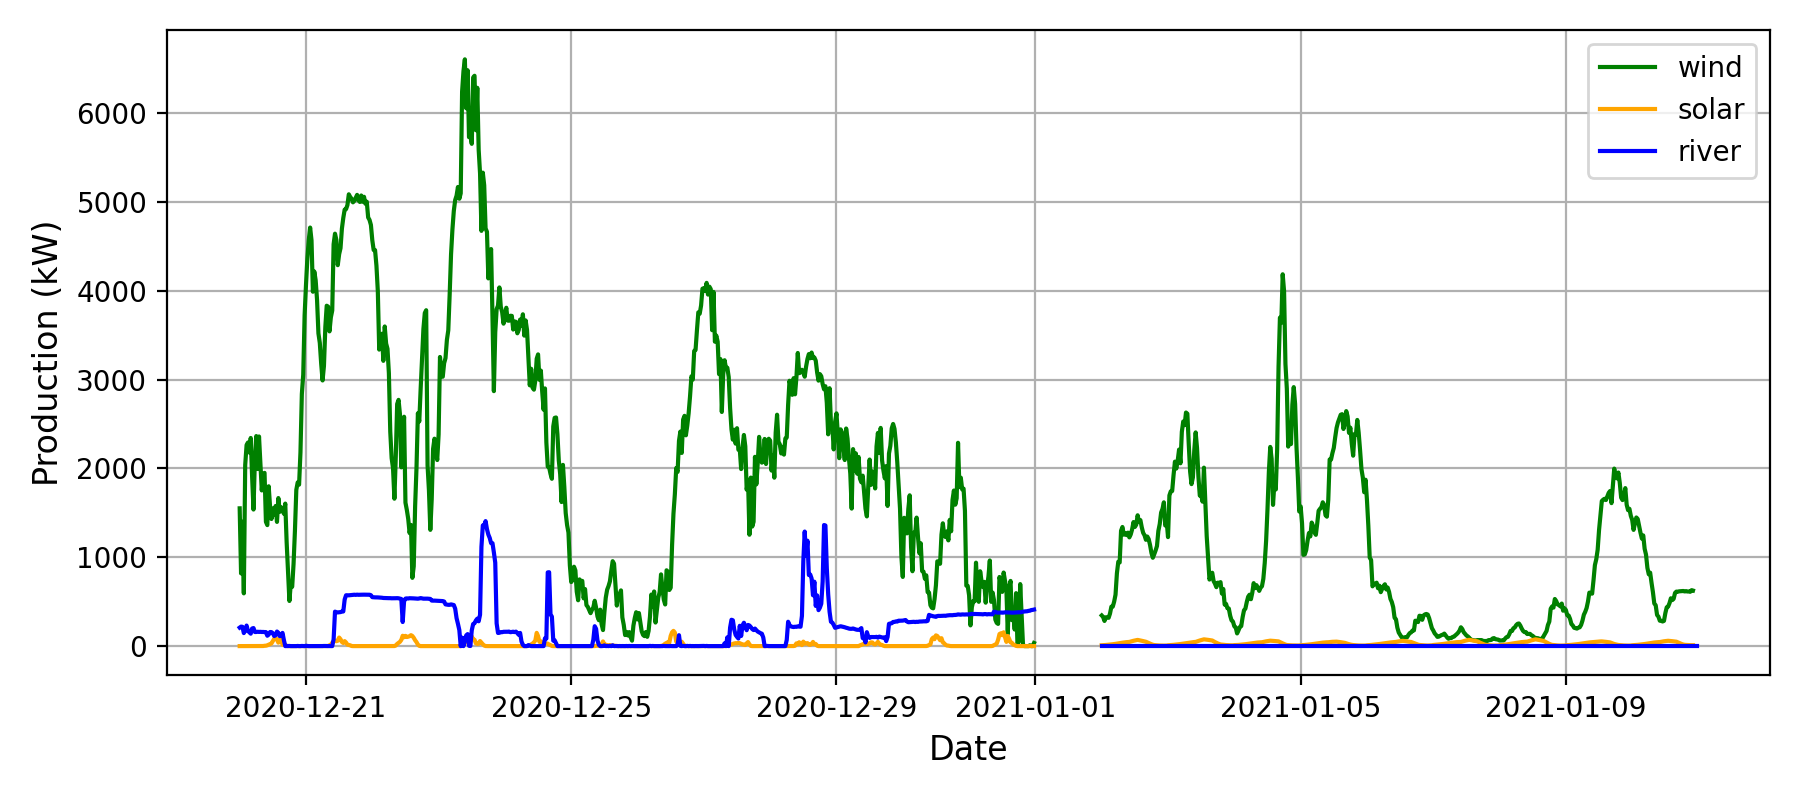

In [54]:
fig, axis = plt.subplots(1, 1, figsize=(9, 4), sharex=True, sharey=False)
axis.grid(True)

for source, data in prediction.items():
    axis.plot(data["power_kw"].groupby(level=1).agg("sum"), label=source, color=colors[source])
    axis.set_xlabel('Date', fontsize=12)
    axis.set_ylabel('Production (kW)', fontsize=12)

for source, data in recent.items():
    axis.plot(data["power_kw"].groupby(level=1).agg("sum"), color=colors[source])
    axis.set_xlabel('Date', fontsize=12)
    axis.set_ylabel('Production (kW)', fontsize=12)
    
axis.legend()
fig.tight_layout()

### Plot predicted data along with the real production 

We stored the real power generation (kW) for the first days of 2021, so that we are able to compare it with the predicted data. Note that in order to obtain a real estimation of the forecasting quality, a complete backtesting should be made. 


<IPython.core.display.Javascript object>


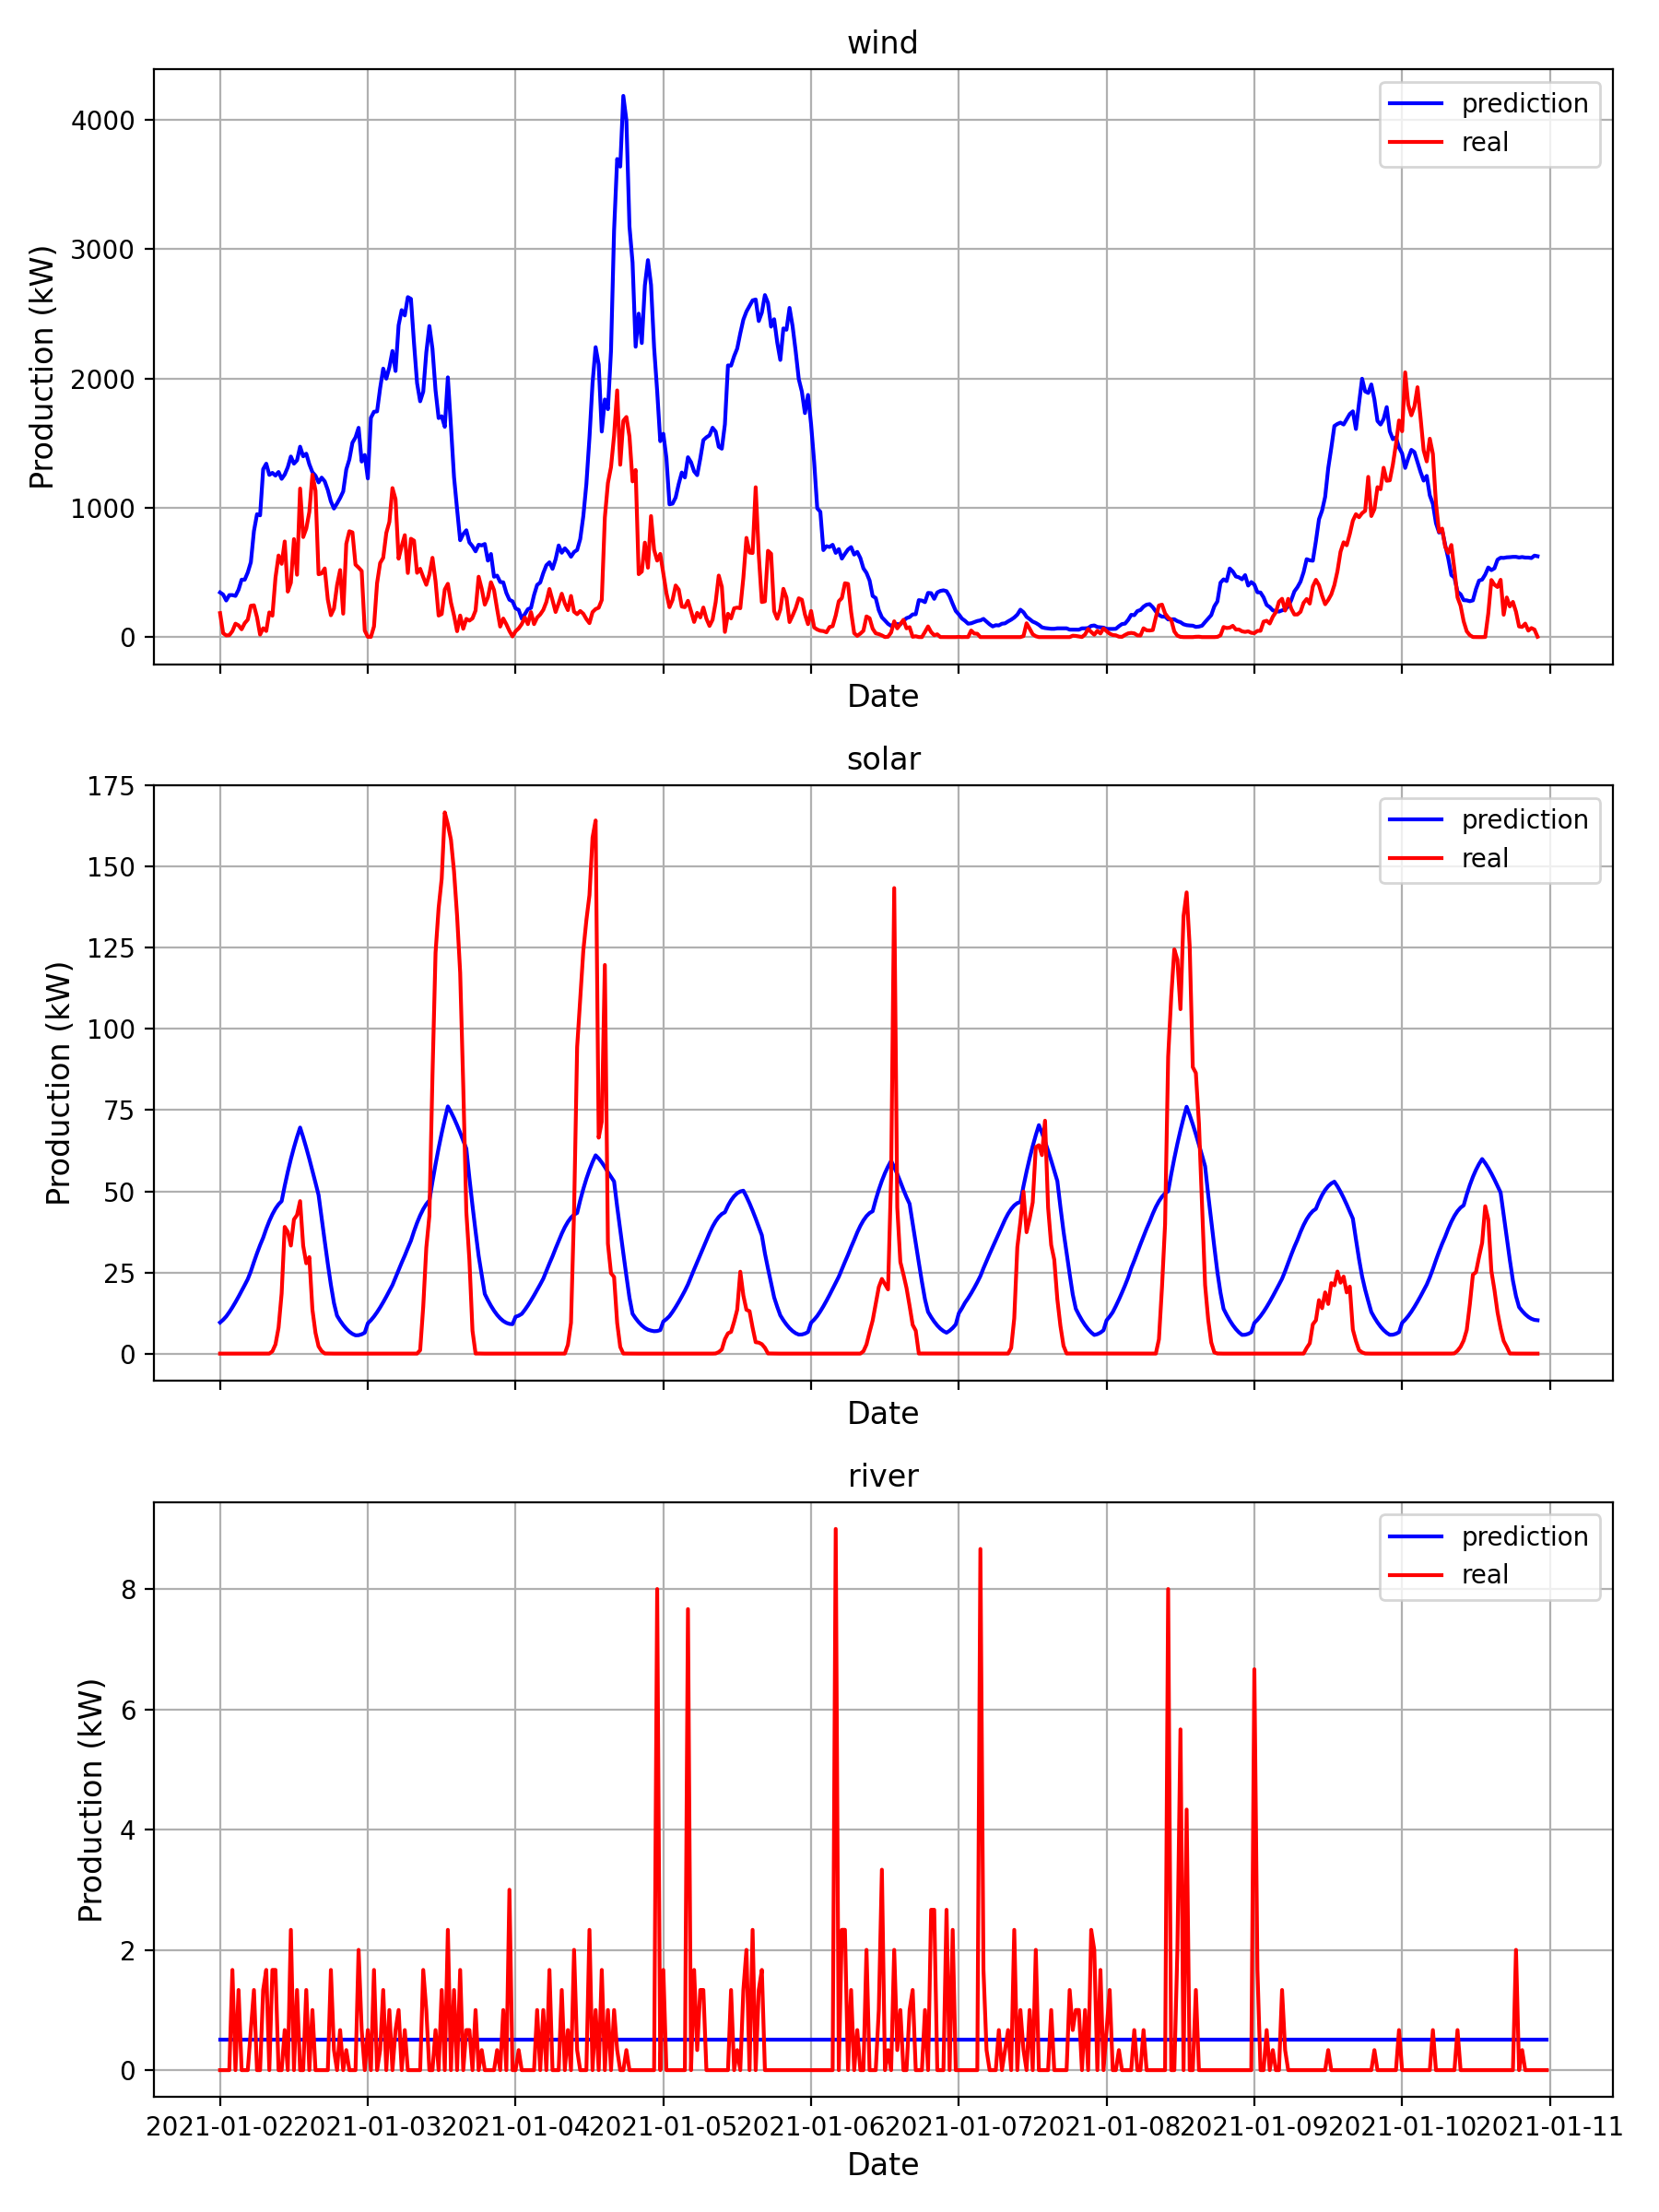

In [55]:
# get back to the power_kw
real = {source: wrapper_compute_power_kw_from_load_factor(r) 
             for source, r in future_set.items()}


fig, axis = plt.subplots(3, 1, figsize=(9, 12), sharex=True, sharey=False)

i = 0
for source, data in prediction.items():
    axis[i].grid(True)
    axis[i].plot(data["power_kw"].groupby(level=1).agg("sum"), label="prediction", c="blue")
    axis[i].set_xlabel('Date', fontsize=12)
    axis[i].set_ylabel('Production (kW)', fontsize=12)
    axis[i].set_title(source)
    i+=1
    
i = 0
for source, data in real.items():
    axis[i].plot(data["power_kw"].groupby(level=1).agg("sum"), label="real", c="red")
    axis[i].set_xlabel('Date', fontsize=12)
    axis[i].set_ylabel('Production (kW)', fontsize=12)
    axis[i].legend()
    i +=1

fig.tight_layout()

Several comments can be made from these plots. 

First and above all, the order of magnitude of the prevision is correct. For the solar and wind prediction moreover - which both use a standard plant approach -, the global trend of the estimation is also correct: when peaks of production are predicted, they indeed appear. For the solar production, it seems quite obvious that a linear predictor is not good enough to anticipate the sharp peaks of the middle of the day. Using a better estimator is let as an exercise ! For the river plants, it looks like the mean production is globally ok, which is the best one can expect using a naive recopy of the more recent mean value. For the wind production, which uses a stronger estimator, the results are not that convincing. However, it must be pointed out that four power plants and one year of data is certainly not enough to produce accurate results. A real-life situation with more data and plants is very likely to produce a better outcome ! 

## Conclusion 

We have been able to build a simple prediction using (or not) a standard power plant approach for a portfolio of plants of different types. It is possible to go further, notably performing a backtesting to explore the performance of the algorithms, and using more data to fill the algorithm, which drastically improve the results.